# EP2420 - Project 1

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import seaborn as sns

### Data import and first analysis

In [2]:
X = pd.read_csv("data/X.csv")
Y = pd.read_csv("data/Y.csv")
X.head()

,TimeStamp,runq-sz,%%memused,proc/s,cswch/s,all_%%usr,ldavg-1,totsck,pgfree/s,plist-sz,file-nr,idel/s,tps
0,1409585052,91,17.30,0.0,75865.0,97.96,122.77,557,80335.0,1019,2976,24.0,11.0
1,1409585053,86,17.31,0.0,74651.0,98.29,122.77,556,74681.0,1019,2976,23.0,0.0
2,1409585054,89,17.32,0.0,78790.0,98.00,122.77,556,78166.0,1019,2976,23.0,0.0
3,1409585055,88,17.33,0.0,75077.0,97.75,122.77,555,74256.0,1019,2976,21.0,0.0
4,1409585056,96,17.32,10.0,72717.0,97.79,122.77,553,84232.0,1011,2976,67.0,2.0


In [3]:
Y = Y.drop("TimeStamp", axis=1)
Y.head()

,DispFrames
0,13.00
1,13.00
2,13.82
3,16.23
4,15.95


Let's mix the features and output datafiles together !

In [4]:
df = X
df["Y"] = Y
df.head()

,TimeStamp,runq-sz,%%memused,proc/s,cswch/s,all_%%usr,ldavg-1,totsck,pgfree/s,plist-sz,file-nr,idel/s,tps,Y
0,1409585052,91,17.30,0.0,75865.0,97.96,122.77,557,80335.0,1019,2976,24.0,11.0,13.00
1,1409585053,86,17.31,0.0,74651.0,98.29,122.77,556,74681.0,1019,2976,23.0,0.0,13.00
2,1409585054,89,17.32,0.0,78790.0,98.00,122.77,556,78166.0,1019,2976,23.0,0.0,13.82
3,1409585055,88,17.33,0.0,75077.0,97.75,122.77,555,74256.0,1019,2976,21.0,0.0,16.23
4,1409585056,96,17.32,10.0,72717.0,97.79,122.77,553,84232.0,1011,2976,67.0,2.0,15.95


## Task 3 - Reduce the Number of Device Statistics to Estimate the Service Metric

### 3.2 Heuristic Method

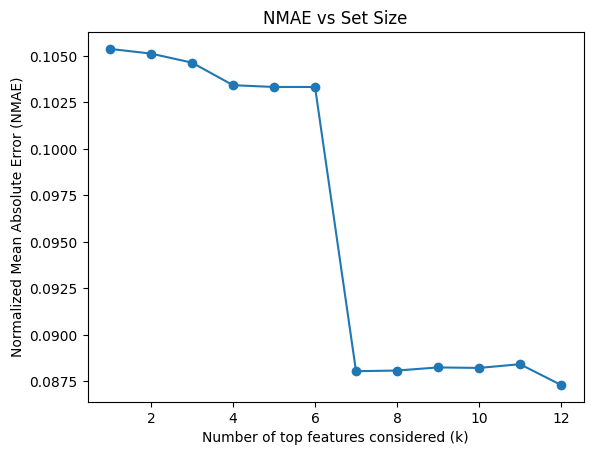

In [5]:
# Creation of the different matrix. The feature matrix X and the service metrics matrix Y.
X = df.drop(labels = ['Y','TimeStamp'],axis = 1)
Y = df['Y']

# Train / Test sets split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7)

m = len(X)

# I calculated the Correlation Coefficient by hand because I wanted to practice handling matrixes (sum, mean , etc.)
sigma_X = np.std(X_train,axis=0)
sigma_Y = np.std(Y_train)

a = X_train - np.mean(X_train,axis=0)
b = Y_train - np.mean(Y_train)

c = a.multiply(b,axis=0)
d = c.divide(sigma_X*sigma_Y)
correlation = np.mean(d,axis=0)

# To sort descending, we just have to ascending sort the inverse of our vector, since the values are POSITIVE
top_features = ((-correlation**2).argsort()).values

model = LinearRegression()
NMAE_heuristic_method = np.zeros(12)

# We take the i best features and train the model with them
for i in range(12):
    features = top_features[:i+1]
    model.fit(X_train.iloc[:,features],Y_train)
    NMAE_heuristic_method[i] = mean_absolute_error(Y_test, model.predict(X_test.iloc[:,features]))/np.mean(Y_test)

plt.plot(np.arange(1,13), NMAE_heuristic_method, marker='o')
plt.xlabel('Number of top features considered (k)')
plt.ylabel('Normalized Mean Absolute Error (NMAE)')
plt.title('NMAE vs Set Size')
plt.show()


In [6]:
# Quick code to check if my correlation computation by hand is correct

df = X_train.copy()
df['Y'] = Y_train

correlation_matrix = df.corr()
z = correlation_matrix ['Y']
sorted_squared_correlations = ((z.drop('Y')**2).sort_values())
print(sorted_squared_correlations)

pgfree/s     0.000286
tps          0.000736
idel/s       0.014605
proc/s       0.023048
%%memused    0.096703
all_%%usr    0.372780
file-nr      0.513897
ldavg-1      0.577813
cswch/s      0.609155
totsck       0.656326
plist-sz     0.663585
runq-sz      0.680963
Name: Y, dtype: float64


In [7]:
(correlation**2).sort_values()

pgfree/s     0.000286
tps          0.000736
idel/s       0.014605
proc/s       0.023048
%%memused    0.096703
all_%%usr    0.372780
file-nr      0.513897
ldavg-1      0.577813
cswch/s      0.609155
totsck       0.656326
plist-sz     0.663585
runq-sz      0.680963
dtype: float64

Okay, now we are sure that the method that I used was correct ! It is important to double check !

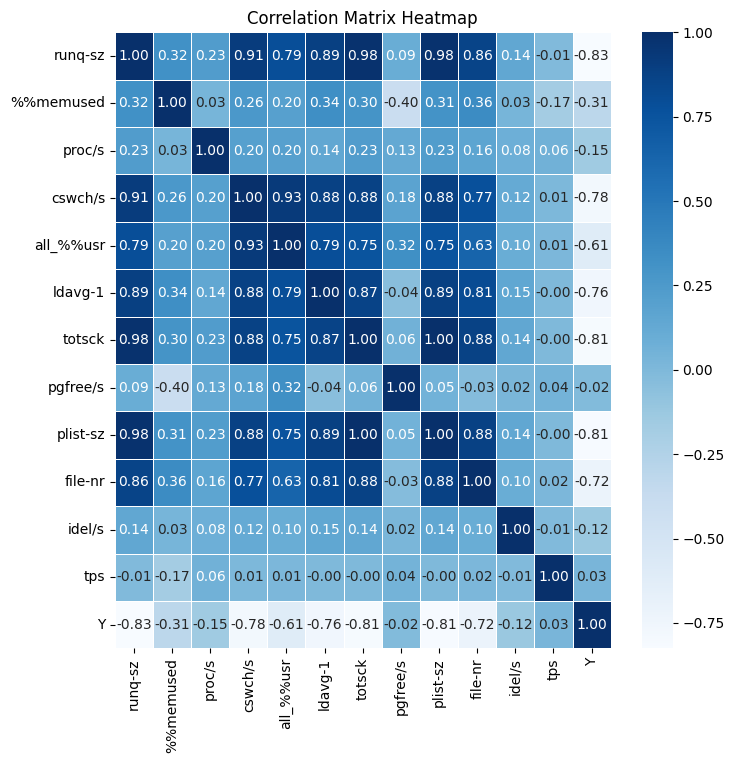

In [8]:
# Creation of the heatmap, with a cmap = 'blues' for more visible results
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

I am using the code of last week to get the Minimum Error for each subset size of the Optimal Method

In [9]:
def subsets(X):
    
    # When we reach the end of the recursive method, we want to return an empty list. 
    # We need to have the empty subset !
    if not X.any() :
        return [[]]

    # We create all the subsets from our set, without the first element
    subsets_without_first = subsets(X[1:])
    first_element = X[0]

    # To create the new subsets, we just add the first element to all these subsets
    subsets_with_first = [subset + [first_element] for subset in subsets_without_first]

    # The result is the combinaison of the subsets without the first elements and the new subsets
    return subsets_without_first + subsets_with_first

all_indices = np.arange(12)
indices_subsets = sorted(subsets(all_indices),key = len) # This allows us to have a sorted list with increasing number of features for each subset
indices_subsets = indices_subsets[1:] # We remove the empty subset since we can't do Linear Regression with that.

# Initialization of minimal NMAE and best subset
NMAE_vector = np.zeros(len(indices_subsets)) # We create this vector to keep the trace of the NMAE for each subset

for i,subset in enumerate(indices_subsets):
    X_train_subset = X_train.iloc[:,subset]
    X_test_subset = X_test.iloc[:,subset]

    model.fit(X_train_subset,Y_train)
    NMAE_vector[i] = mean_absolute_error(Y_test,model.predict(X_test_subset))/np.mean(Y_test)

NMAE_optimal_method = np.zeros(12)
for i in range(1,13):

    indices_subset_len_i = [index for index, element in enumerate(indices_subsets) if len(element) == i]
    NMAE_optimal_method[i-1] = np.min(NMAE_vector[indices_subset_len_i])

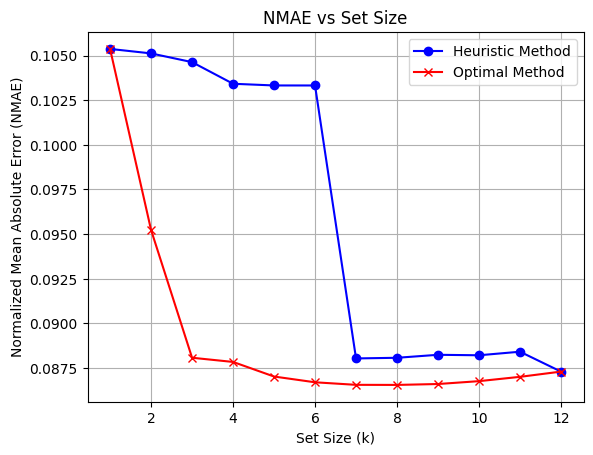

In [10]:
plt.plot(np.arange(1,13), NMAE_heuristic_method, marker='o',c='b',label='Heuristic Method')
plt.plot(np.arange(1,13), NMAE_optimal_method, marker='x',c='r', label ='Optimal Method')
plt.xlabel('Set Size (k)')
plt.ylabel('Normalized Mean Absolute Error (NMAE)')
plt.title('NMAE vs Set Size')
plt.legend()
plt.grid(True)
plt.show()

## Task 4 Dimensionality reduction using Principal Component Analysis (PCA)

1. 

In [11]:
from sklearn.decomposition import PCA

NMAE_PCA = np.zeros(12)

for k in np.arange(1,13):

    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model.fit(X_train_pca, Y_train)
    
    Y_pred_pca = model.predict(X_test_pca)

    NMAE_PCA[k-1] = mean_absolute_error(Y_test,Y_pred_pca) / np.mean(Y_test)

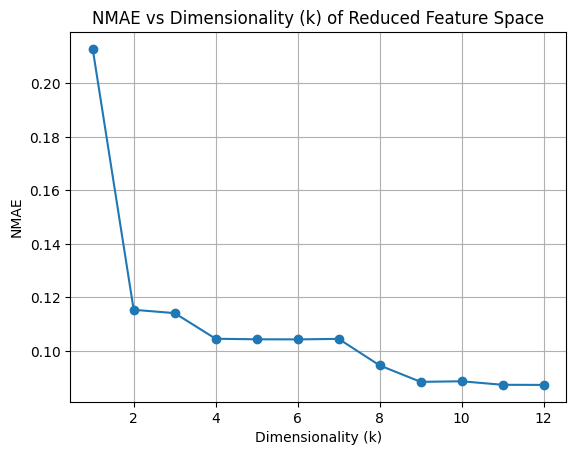

In [12]:
plt.plot(np.arange(1,13), NMAE_PCA, marker='o')
plt.title('NMAE vs Dimensionality (k) of Reduced Feature Space')
plt.xlabel('Dimensionality (k)')
plt.ylabel('NMAE')
plt.grid(True)
plt.show()

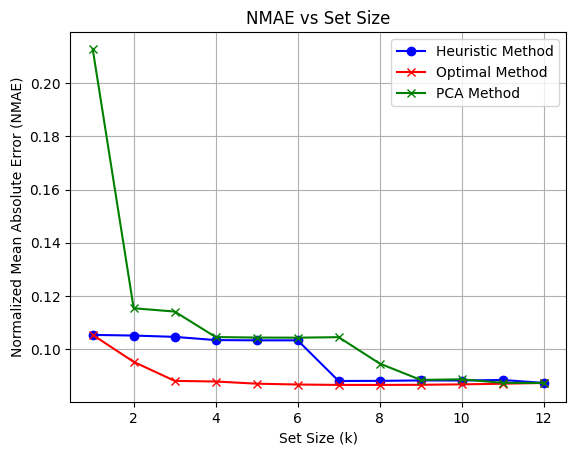

In [13]:
plt.plot(np.arange(1,13), NMAE_heuristic_method, marker='o',c='b',label='Heuristic Method')
plt.plot(np.arange(1,13), NMAE_optimal_method, marker='x',c='r', label ='Optimal Method')
plt.plot(np.arange(1,13), NMAE_PCA, marker='x',c='g', label ='PCA Method')
plt.xlabel('Set Size (k)')
plt.ylabel('Normalized Mean Absolute Error (NMAE)')
plt.title('NMAE vs Set Size')
plt.legend()
plt.grid(True)
plt.show()